In [21]:
from brainlit.utils.ngl_pipeline import NeuroglancerSession
from brainlit.preprocessing.features import *
from brainlit.preprocessing import gabor_filter
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from scipy import interp
from scipy import mean
from sklearn import preprocessing
from scipy.stats import sem, t
import matplotlib.pyplot as plt

In [2]:
nbr = NeighborhoodFeatures(url="s3://mouse-light-viz/precomputed_volumes/brain1", size=[5,5,5], offset=[15,15,15])
df_nbr = nbr.fit(seg_ids=[2], num_verts=1000)

Downloading:   0%|          | 0/1 [00:00<?, ?it/s]


In [19]:
df_nbr.to_pickle("neighborhoods.xz")

In [7]:
labels  = np.asarray(df_nbr["Label"])

In [35]:
phi_1 = [0,0]
phi_2 = np.pi/2
frequency = [0.1, 0.25, 0.5, 1, 2, 2.5, 5, 10]
kf = KFold(n_splits=4)
base_fpr = np.linspace(0, 1, 100)
i = 0
for freq in frequency:
    for index,row in df_nbr.iterrows():
        nprow  = np.asarray(row["Features"]['[5, 5, 5]'])
        img = nprow.reshape(11,11,11)
        voxel = (np.subtract(img.shape, 1) / 2).astype(int)

        g = ndi.gaussian_filter(img, [1, 1, 0.3])
        g = float(g[[voxel[0]], [voxel[1]], [voxel[2]]])

        gg = ndi.gaussian_gradient_magnitude(img, [1, 1, 0.3])
        gg = float(gg[[voxel[0]], [voxel[1]], [voxel[2]]])

        gl = ndi.gaussian_laplace(img, [1, 1, 0.3])
        gl = float(gl[[voxel[0]], [voxel[1]], [voxel[2]]])

        gb1 = gabor_filter(img, [1, 1, 0.3], phi_1, freq)[0]
        gb1 = float(gb1[[voxel[0]], [voxel[1]], [voxel[2]]])

        gb2 = gabor_filter(img, [1, 1, 0.3], phi_1, freq)[0]
        gb2 = float(gb2[[voxel[0]], [voxel[1]], [voxel[2]]])

        if index == 0:
            result = np.concatenate((nprow, [g, gg, gl, gb1, gb2]))
        else:
            result = np.vstack((result, np.concatenate((nprow, [g, gg, gl, gb1, gb2]))))

    preprocesser = preprocessing.StandardScaler().fit(result)
    lin_data = preprocesser.transform(result) 

    inner_auc = []
    inner_tprs = []

    for train_index, test_index in kf.split(labels):
        X_train, X_test = lin_data[train_index,:], lin_data[test_index,:]
        y_train, y_test = labels[train_index], labels[test_index]

        clf = LogisticRegression(max_iter = 1000)
        clf.fit(X_train, y_train)
        predictions = clf.predict_proba(X_test)[:,1]
        inner_auc.append(metrics.roc_auc_score(y_test, predictions))

        temp_fpr, temp_tpr, _ = metrics.roc_curve(y_test, predictions)
        temp_tpr = interp(base_fpr, temp_fpr, temp_tpr)
        temp_tpr[0] = 0.0
        inner_tprs.append(temp_tpr)
    
    mid, high, low = compute_confidence(np.asarray(inner_tprs))
    if i == 0:
        final_auc = np.asarray(inner_auc)
        final_mid = np.asarray(mid)
        final_high = np.asarray(high)
        final_low = np.asarray(low)
    else:
        final_auc = np.vstack((final_auc, np.asarray(inner_auc)))
        final_mid = np.vstack((final_mid, np.asarray(mid)))
        final_high = np.vstack((final_high, np.asarray(high)))
        final_low = np.vstack((final_low, np.asarray(low)))

    i += 1

In [29]:
def compute_confidence(x):
	if x.ndim == 2:
		mid = []
		up = []
		low = []
		for i in range(len(x[0])):
			data = x[:,i].flatten()
			n = len(data)
			m = mean(data)
			std_err = sem(data)
			h = std_err * t.ppf((1 + 0.95)/2, n-1)
			mid.append(m)
			up.append(m+h)
			low.append(m-h)
		return mid, up, low
	else:
		n = len(x)
		m = mean(x)
		std_err = sem(x)
		h = std_err * t.ppf((1 + 0.95)/2, n-1)
		mid = m
		up = m+h
		low = m-h
		return mid, up, low

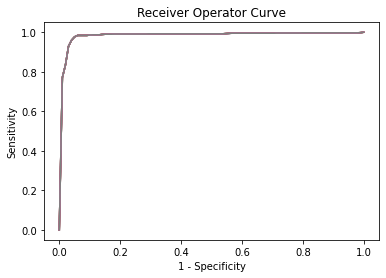

In [38]:
plt.figure()
for i in range(len(final_auc)):
    plt.plot(base_fpr, final_mid[i])
    #plt.fill_between(base_fpr, final_low[i], final_high[i], color='grey', alpha=0.3)
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("Receiver Operator Curve")
plt.show()

[[0.979568 0.976088 0.99256  0.989584]
 [0.979584 0.976088 0.99256  0.989584]
 [0.979568 0.976088 0.99256  0.989584]
 [0.979568 0.976088 0.99256  0.989584]
 [0.979568 0.976088 0.99256  0.989584]
 [0.979568 0.976088 0.99256  0.989584]
 [0.979568 0.976088 0.99256  0.989584]
 [0.979568 0.976088 0.99256  0.989584]]
